In [2]:
import numpy as np
import matplotlib.pyplot as plt
from celmech.secular import SecularSystemSimulation,LaplaceLagrangeSystem
import rebound as rb
from celmech.nbody_simulation_utilities import set_timestep, align_simulation, get_simarchive_integration_results

In [3]:
# Define a method to integrate a secular simulation and return results near a series of user-specified times
def run_secular_sim(sec_sim,times, **kwargs):
    N = len(times)
    eccN,incN,pomegaN,OmegaN = np.zeros((4,sec_sim.state.N - 1,N))
    Eerr = np.zeros(N)
    AMDerr = np.zeros(N)
    timesDone = np.zeros(N)
    E0 = sec_sim.calculate_energy()
    AMD0 = sec_sim.calculate_AMD()
    for i,time in enumerate(times):
        sec_sim.integrate(time,**kwargs)
        timesDone[i] = sec_sim.t
        E = sec_sim.calculate_energy()
        AMD = sec_sim.calculate_AMD()
        Eerr[i] = np.abs((E-E0)/E0)
        AMDerr[i] = np.abs((AMD-AMD0)/AMD0)
        for j,p in enumerate(sec_sim.state.particles[1:]):
            eccN[j,i] = p.e
            incN[j,i] = p.inc
            pomegaN[j,i] = p.pomega
            OmegaN[j,i] = p.Omega
    return timesDone, Eerr, AMDerr, eccN, incN,pomegaN,OmegaN

The example system is generated from a random draw of the TTV fit posteriors for Kepler-23. 
The planets have been given some (unrealistically) large mutual inclinations in order make the effects of non-linear secular terms more dramatic.

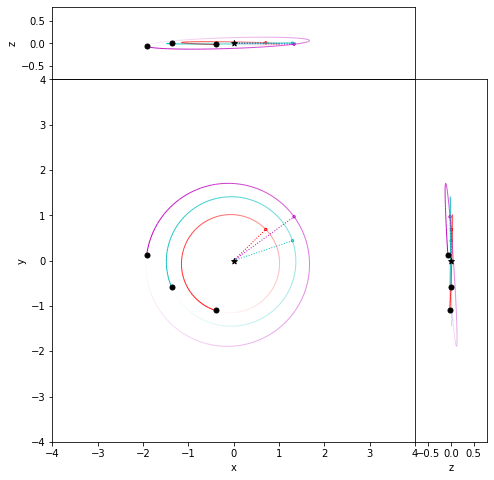

In [3]:
# Get initial conditions
sim = rb.Simulation('./Kepler-23_Nonlinear_Secular_Example.bin')
ps= sim.particles
# Show orbit plot
rb.OrbitPlot(sim,xlim=(-4,4),ylim=(-4,4),slices=0.2,color=True,periastron=True);

### $N$-body simulation

We'll start by running an $N$-body simulation of our system for a million orbital timescales.

I find this takes about ~25 seconds using direct N-body simulation.

In [4]:
sa_file = './Kepler-23_Nonlinear_Secular_Example.sa'
try:
    sa = rb.SimulationArchive(sa_file)
except:
    sim.automateSimulationArchive(sa_file,interval=500 * ps[1].P)
    sim.integrator = 'whfast'
    sim.ri_whfast.safe_mode=0
    set_timestep(sim,1/25.)
    %time sim.integrate(1e6 * ps[1].P)
    sa = rb.SimulationArchive(sa_file)

In [5]:
nbody_results = get_simarchive_integration_results(sa)

### Comparison with Laplace-Lagrange theory
Now we'll compare the predictions of Laplace-Lagrange theory with the results of our $N$-body simulataion using `celmech`'s `LaplaceLagrangeSystem` class.

As you can see below, the agreement isn't great.

In [6]:
llsys = LaplaceLagrangeSystem.from_Simulation(sa[0])

ll_results = llsys.secular_solution(nbody_results['time'])

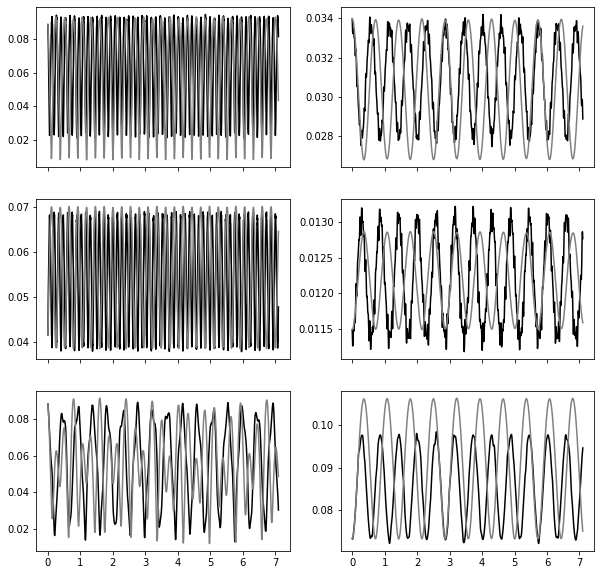

In [7]:
fig,ax = plt.subplots(3,2,sharex=True,figsize=(10,10))
for i in range(3):
    ax[i,0].plot(nbody_results['time']/1e6,nbody_results['e'][i],'k')
    ax[i,0].plot(ll_results['time']/1e6,ll_results['e'][i],'gray')
    
    ax[i,1].plot(nbody_results['time']/1e6,nbody_results['inc'][i],'k')
    ax[i,1].plot(ll_results['time']/1e6,ll_results['inc'][i],'gray')

### Non-linear secular simulation 

Since Laplace-Lagrange theory doesn't do a great job, let's try 
simulating the secular system including nonlinear terms.

In [28]:
sec_sim = SecularSystemRKIntegrator.from_Simulation(
    sa[0],
    dtFraction=1/40,
    max_order=4,
    DFOp_kwargs={'rtol':1e-10,'rkmethod':'GL4'}
)

In [29]:
Tsec = llsys.Tsec
secSimTimes = np.linspace(0,sa[-1].t,256)
%time timesDone, Eerr, AMDerr, eccN, incN,pomegaN,OmegaN = run_secular_sim(sec_sim,secSimTimes)

CPU times: user 7.71 s, sys: 591 ms, total: 8.31 s
Wall time: 4.22 s


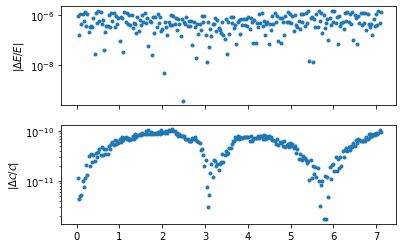

In [30]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(timesDone/1e6,Eerr,'.')
ax[1].plot(timesDone/1e6,AMDerr,'.')
#ax[0].set_ylim(1e-5,0.5e-2)
ax[0].set_ylabel(r"$|\Delta E/E|$")
ax[1].set_ylabel(r"$|\Delta {\cal C}/{\cal C}|$")
for a in ax:
    a.set_yscale('log')
# ax[1].axhline(1e-10,color='k',ls='--')    
# ax[0].set_ylim(ymin=1e-9);
# ax[1].set_ylim(ymin=1e-13);

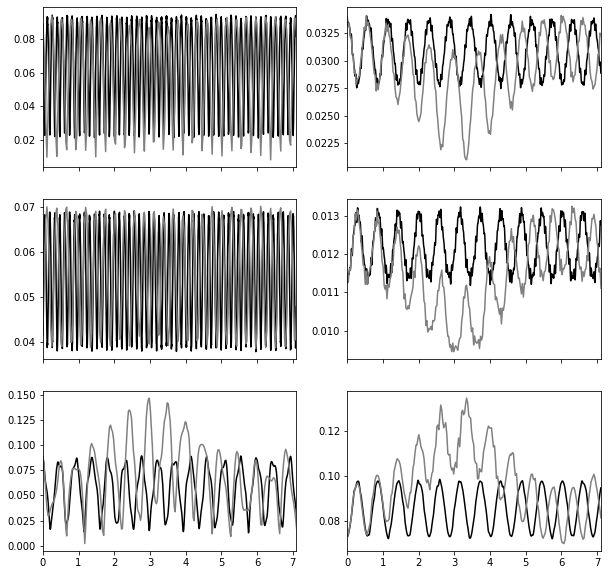

In [31]:
fig,ax = plt.subplots(3,2,sharex=True,figsize=(10,10))
for i in range(3):
    ax[i,0].plot(nbody_results['time']/1e6,nbody_results['e'][i],'k')
    ax[i,0].plot(timesDone/1e6,eccN[i],'gray')
    
    ax[i,1].plot(nbody_results['time']/1e6,nbody_results['inc'][i],'k')
    ax[i,1].plot(timesDone/1e6,incN[i],'gray')
    
for a in ax:
    a[0].set_xlim(0, nbody_results['time'][-1]/1e6)
    a[1].set_xlim(0, nbody_results['time'][-1]/1e6)

In [32]:
from celmech import Poincare
from celmech.generating_functions import FirstOrderGeneratingFunction

In [33]:
res_to_include=dict()
res_to_include[(1,2)] = [(3,1)]
res_to_include[(2,3)] = [(3,1),(10,3),(4,1)]



In [39]:
pvars = Poincare.from_Simulation(sa[0])
pchi = FirstOrderGeneratingFunction(pvars)
# Add terms we want to eliminate
for pair, res_list in res_to_include.items():
    iIn,iOut = pair
    for res in res_list:
        p,q = res
        pchi.add_eccentricity_MMR_terms(p,q,max(q,2),indexIn=iIn,indexOut=iOut,update=False)
pchi.add_zeroth_order_term(1,2,update=False)
pchi.add_zeroth_order_term(1,3,update=False)
pchi.add_zeroth_order_term(2,3,update=True)
pchi.osculating_to_mean()

In [40]:
sec_sim2 = SecularSystemRKIntegrator(
    pvars,
    dtFraction=1/40,
    max_order=6,
    resonances_to_include=res_to_include,
    DFOp_kwargs={'rtol':1e-10,'rkmethod':'GL4'}
)

In [41]:
Tsec = llsys.Tsec
%time timesDone2, Eerr2, AMDerr2, eccN2, incN2,pomegaN2,OmegaN2 = run_secular_sim(sec_sim2,secSimTimes)

CPU times: user 15.6 s, sys: 979 ms, total: 16.6 s
Wall time: 8.39 s


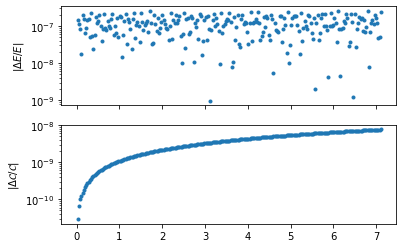

In [42]:
fig,ax = plt.subplots(2,1,sharex=True)
ax[0].plot(timesDone/1e6,Eerr2,'.')
ax[1].plot(timesDone/1e6,AMDerr2,'.')
#ax[0].set_ylim(1e-5,0.5e-2)
ax[0].set_ylabel(r"$|\Delta E/E|$")
ax[1].set_ylabel(r"$|\Delta {\cal C}/{\cal C}|$")
for a in ax:
    a.set_yscale('log')
# ax[1].axhline(1e-10,color='k',ls='--')    
# ax[0].set_ylim(ymin=1e-9);
# ax[1].set_ylim(ymin=1e-13);

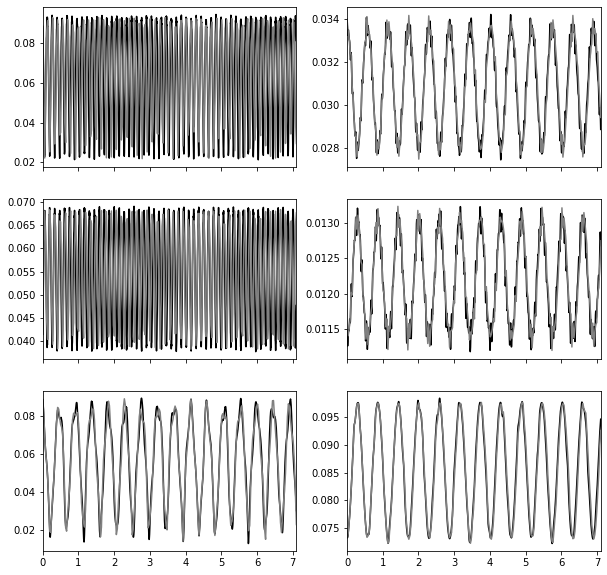

In [45]:
fig,ax = plt.subplots(3,2,sharex=True,figsize=(10,10))
for i in range(3):
    ax[i,0].plot(nbody_results['time']/1e6,nbody_results['e'][i],'k')
    ax[i,0].plot(timesDone2/1e6,eccN2[i],'gray')
    
    ax[i,1].plot(nbody_results['time']/1e6,nbody_results['inc'][i],'k')
    ax[i,1].plot(timesDone2/1e6,incN2[i],'gray')
    
for a in ax:
    a[0].set_xlim(0, nbody_results['time'][-1]/1e6)
    a[1].set_xlim(0, nbody_results['time'][-1]/1e6)

### Examine secular mode decomposition of simulation results

In [ ]:
from celmech.miscellaneous import frequency_modified_fourier_transform

In [ ]:
zN = eccN * np.exp(1j * pomegaN)
zetaN = np.sin(incN/2) * np.exp(1j * OmegaN)

In [ ]:
Nsample=len(timesDone)//2
print("Eccentricity mode decomposition")
for i in range(3):
    fFirst = frequency_modified_fourier_transform(timesDone[:Nsample],zN[i][:Nsample],3)
    fLast = frequency_modified_fourier_transform(timesDone[:Nsample],zN[i][Nsample:],3)
    fFirst_arr = np.array(list(fFirst.keys()))
    fLast_arr = np.array(list(fLast.keys()))
    dfs = 0.5 * np.abs(fFirst_arr - fLast_arr) / (fFirst_arr + fLast_arr) 
    for f,df in zip(fFirst,dfs):
        print("{} freq: {:.4g}, amp: {:.4g}, df: {:.4g}".format(i,f,np.abs(fFirst[f]),df))
    print("")

    
    

In [ ]:
print("Inclination mode decomposition")
for i in range(3):
    fFirst = frequency_modified_fourier_transform(timesDone[:Nsample],zetaN[i][:Nsample],2)
    fLast = frequency_modified_fourier_transform(timesDone[:Nsample],zetaN[i][Nsample:],2)
    fFirst_arr = np.array(list(fFirst.keys()))
    fLast_arr = np.array(list(fLast.keys()))
    dfs = 0.5 * np.abs(fFirst_arr - fLast_arr) / (fFirst_arr + fLast_arr) 
    for f,df in zip(fFirst,dfs):
        print("{} freq: {:.4g}, amp: {:.4g}, df: {:.4g}".format(i,f,np.abs(fFirst[f]),df))
    print("")

    
    